In [1]:
import pandas as pd
import json
import ast
from matplotlib import pyplot as plt
from pathlib import Path
import subprocess
import os

In [9]:
# download all human paired antibody data with no known disease labels
# https://opig.stats.ox.ac.uk/webapps/oas/oas_paired/
subprocess.call(['sh', 'bulk_download.sh'], 
                stdout=subprocess.DEVNULL, 
                stderr=subprocess.DEVNULL
                ) # suppress output

0

In [15]:
# grab all the data file and join in a single dataframe
data_dir = Path("data")
sequences = []
metadata = {}

meta_idx = 0
for filename in data_dir.glob('*.csv.gz'):
    metadata[meta_idx] = json.loads(','.join(pd.read_csv(filename, nrows=0).columns))
    seq = pd.read_csv(filename, header=1)
    seq['meta_idx'] = meta_idx
    sequences.append(seq)
    
    meta_idx += 1

df = pd.concat(sequences, ignore_index=True)
print(df.shape)

/scratch/lsftmp/8126244.tmpdir/ipykernel_22237/1770897806.py:9: DtypeWarning: Columns (109,125,126,127,128,155,191) have mixed types. Specify dtype option on import or set low_memory=False.
  seq = pd.read_csv(filename, header=1)
/scratch/lsftmp/8126244.tmpdir/ipykernel_22237/1770897806.py:9: DtypeWarning: Columns (109,125,126,127,128,155) have mixed types. Specify dtype option on import or set low_memory=False.
  seq = pd.read_csv(filename, header=1)


(568139, 199)


In [16]:
metadata[0]

{'Run': 'AT7mc_S2_',
 'Link': 'https://doi.org/10.1038/s41590-022-01230-1',
 'Author': 'Phad et al., 2022',
 'Species': 'human',
 'Age': 'no',
 'BSource': 'PBMC',
 'BType': 'Memory-B-Cells',
 'Vaccine': 'None',
 'Disease': 'None',
 'Subject': 'Donor-1',
 'Longitudinal': 'Year-2010',
 'Unique sequences': 6522,
 'Isotype': 'All',
 'Chain': 'Paired'}

- `Age`: Information on age of the human B-cell donors.
- `Disease`: Indicates whether the donor was sick at the time of B-cell extraction.
- `Vaccine`: Indicates whether the B-cell donor was purposely immunised prior to B-cell - extraction.
- `BType`: Indicates whether B-cells were experimentally sorted prior to sequencing.
- `Species`: Organism of the B-cell donor.
- `Author`: First author and the publication year.
- `Unique`: sequences Number of sequences that passed quality filtering steps.
- `BSource`: Which organ/tissue the B-cells were extracted from.
- `Subject`: Indicates whether the B-cells can be tracked back to a particular individual.
- `Longitudinal`: If the study is conducted over a period of time, indicates the particular timepoint when B-cells were sourced.

![](assets/antibody.webp)

To better break down the data, it is helpful to understand the biology of an antibody. In textbooks, an antibody structure is drawn as a "Y". We typically treat the left and right side as symmetric (in sequence, structure, and function). Each side is composed of a **light chain** and a **heavy chain**. 

The primary difference is that the heavy chain is longer (Figure below). The additional length comes from the **Fc region** (the foot of the "Y"), which mediates interaction with immune cells. There are a few types of Fc region sequences, which determines the types of immune cells that the antibody actives. The Fc region type determines the isotype of the antibody -- IgG, IgM, IgA, IgD, IgE. 

On the other hand, the light and heavy chain shares a **Fab region** (the arms of the "Y"), which interact with antigens (the binding targets). The Fab region of the light and heavy chain have enormous structural diversity and biologists have developed a detailed classification scheme based on the maturation process of antibodies. 

Most of the diversity of Fab region stems from the **Fv region** (tip of the "Y", shaded in red). Some work on antibody modeling have focused exclusively on the Fv region and ignored other regions. The content below exclusively focus on the Fv region.

There are 2 orthogonal ways to subdivide the Fv region, based on a genetic perspective and a structural/functional perspective:
* Genetic sequence - VDJ classification: The Fv region is encoded by 3 gene segments - V, D, J. There are 100s of variants for each gene within each individual, which encodes the 1st line of antibody diversity.
* Structural/Functional - CDRs and FWRs: The **CDRs (complement determining regions)** of the antibody contacts the antigen and determines binding, therefore they mutates more during B cell maturation. Meanwhile, the **FWRs (framework regions)** are thought to be structural scaffolds and mutate to a lesser extend. The Fv region is composed of 3 CDRs interspersed between 4 FWRs. The CDRs are often depicted as "fingers" and the FWRs the "palms" of a hand.

There are two major mechanisms of diversity:
1. **VDJ recombination**: Early on in a B cell's life, it selects 1 of each V,D, and J genes from 100s of isoforms. The selected segments are joined by double-stranded break repair, which inserts random nucleotides between the V,D,J segments, called **NP nucleotides**. This will become the very first antibodies they express. 
2. **Selection and maturation**: After B cells start expressing antibodies, they are "trained" in lymph nodes to ensure they are not autoimmune, while selecting those that strongly targets antigens. Clones - populations with the same genetic makeup - that survive the selection grows and mutates, conferring further diversity.


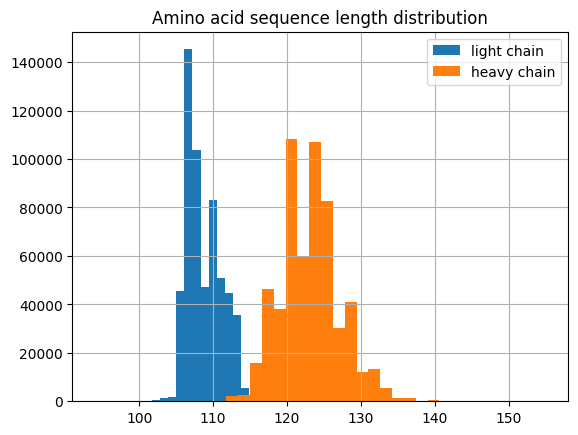

In [17]:
df['sequence_alignment_aa_light'].str.len().hist(bins=30, label='light chain')
df['sequence_alignment_aa_heavy'].str.len().hist(bins=30, label='heavy chain')
plt.title('Amino acid sequence length distribution')
plt.legend()

There are a 198 columns in total (I added one additional column for indexing into the metadata). 

This is overwhelming on first sight, but with the biology in mind we can make sense of all the information. I find it helpful to break down the information hierarchically.

In [18]:
print(len(df.columns))
print(list(df.columns))

199
['sequence_id_heavy', 'sequence_heavy', 'locus_heavy', 'stop_codon_heavy', 'vj_in_frame_heavy', 'v_frameshift_heavy', 'productive_heavy', 'rev_comp_heavy', 'complete_vdj_heavy', 'v_call_heavy', 'd_call_heavy', 'j_call_heavy', 'sequence_alignment_heavy', 'germline_alignment_heavy', 'sequence_alignment_aa_heavy', 'germline_alignment_aa_heavy', 'v_alignment_start_heavy', 'v_alignment_end_heavy', 'd_alignment_start_heavy', 'd_alignment_end_heavy', 'j_alignment_start_heavy', 'j_alignment_end_heavy', 'v_sequence_alignment_heavy', 'v_sequence_alignment_aa_heavy', 'v_germline_alignment_heavy', 'v_germline_alignment_aa_heavy', 'd_sequence_alignment_heavy', 'd_sequence_alignment_aa_heavy', 'd_germline_alignment_heavy', 'd_germline_alignment_aa_heavy', 'j_sequence_alignment_heavy', 'j_sequence_alignment_aa_heavy', 'j_germline_alignment_heavy', 'j_germline_alignment_aa_heavy', 'fwr1_heavy', 'fwr1_aa_heavy', 'cdr1_heavy', 'cdr1_aa_heavy', 'fwr2_heavy', 'fwr2_aa_heavy', 'cdr2_heavy', 'cdr2_aa_he

In [19]:
df.head()

,sequence_id_heavy,sequence_heavy,locus_heavy,stop_codon_heavy,vj_in_frame_heavy,v_frameshift_heavy,productive_heavy,rev_comp_heavy,complete_vdj_heavy,v_call_heavy,...,np1_light,np1_length_light,np2_light,np2_length_light,c_region_light,Isotype_light,Redundancy_light,ANARCI_numbering_light,ANARCI_status_light,meta_idx
0,AAACCTGAGAGCAATT-1_contig_2,AGCTCTCAGAGAGGAGCCCAGCCCTGGGATTTTCAGGTGTTTTCAT...,H,F,T,F,T,F,T,IGHV3-23*01,...,NaN,0.0,NaN,NaN,GAACTGTGGCTGCACCATCTGTCTTCATCTTCCCGCCATCTGATGA...,Bulk,1.0,"{'fwk1': {'1 ': 'A', '2 ': 'I', '3 ': 'Q', '4 ...",|||||,0
1,AAACCTGAGATCTGCT-1_contig_2,GAGGAGCCCCAGCCCTGGGATTCCCAGCTGTTTCTGCTTGCTGATC...,H,F,T,F,T,F,T,IGHV3-74*01,...,NaN,0.0,NaN,NaN,GAACTGTGGCTGCACCATCTGTCTTCATCTTCCCGCCATCTGATGA...,Bulk,1.0,"{'fwk1': {'1 ': 'E', '2 ': 'I', '3 ': 'V', '4 ...",|||||,0
2,AAACCTGAGCAGCCTC-1_contig_2,TGGGGGCTTTCTGAGAGTCATGGACCTCCTGTGCAAGAACATGAAG...,H,F,T,F,T,F,T,IGHV4-39*07,...,TTT,3.0,NaN,NaN,GAACTGTGGCTGCACCATCTGTCTTCATCTTCCCGCCATCTGATGA...,Bulk,1.0,"{'fwk1': {'1 ': 'A', '2 ': 'I', '3 ': 'Q', '4 ...",|||||,0
3,AAACCTGAGCAGGTCA-1_contig_2,GGAGTCTCCCTCACTGCCCAGCTGGGATCTCAGGGCTTCATTTTCT...,H,F,T,F,T,F,T,IGHV5-51*01,...,GGGA,4.0,NaN,NaN,GTCAGCCCAAGGCTGCCCCCTCGGTCACTCTGTTCCCGCCCTCCTC...,Bulk,1.0,"{'fwl1': {'1 ': 'Q', '2 ': 'S', '3 ': 'A', '4 ...",|||||,0
4,AAACCTGAGCTTCGCG-1_contig_2,GGAGTCTCCCTCACTGCCCAGCTGGGATCTCAGGGCTTCGTTTTCT...,H,F,T,F,T,F,T,IGHV5-51*01,...,GT,2.0,NaN,NaN,GTCAGCCCAAGGCTGCCCCCTCGGTCACTCTGTTCCCGCCCTCCTC...,Bulk,1.0,"{'fwl1': {'1 ': 'Q', '2 ': 'S', '3 ': 'A', '4 ...",|||||,0


**Data Schematic** 

[Heavy/Light] chain-level info:
- `sequence_[heavy/light]`: complete DNA sequence
- `sequence_alignment_[heavy/light]`: DNA sequence aligned to the variable region. (V starts at position 1)
- `germline_alignment_[heavy/light]`: putative germline DNA sequence aligned to the variable region.
- `sequence_alignment_aa_[heavy/light]`: amino acid sequence aligned to the VDJ region.
- `germline_alignment_aa_[heavy/light]`: germline amino acid sequence (nearest IMGT reference ensemble). 
- `c_region_[heavy/light]`: DNA sequence of the constant region
- `Isotype_[heavy/light]`: Antibody isotype (IgA/D/E/G/M). 'Bulk' if unclassified. `Isotype_light` should be mostly 'Bulk' since the heavy chain determines the isotype.
- VDJ classification info:
    - `[v/d/j]_sequence_alignment_[heavy/light]`: reference-aligned V/D/J DNA sequence
    - `[v/d/j]_sequence_alignment_aa_[heavy/light]`: reference-aligned V/D/J amino acid sequence
    - `[v/d/j]_germline_alignment_[heavy/light]`: putative germline V/D/J DNA sequence
    - `[v/d/j]_germline_alignment_aa_[heavy/light]`: putative germline V/D/J amino acid sequence
    - `[v/d/j]_call_[heavy/light]`: IMGT reference sequence best matched (one of the 100s of VDJ variants)
    - `[v/d/j]_alignment_[start/end]_[heavy/light]`: the start and end nucleotide of the V/D/J region in `sequence_alignment_[heavy/light]`
    - `[v/d/j]_sequence_[start/end]_[heavy/light]`: the start and end nucleotide of the V/D/J region in `sequence_[heavy/light]`
    - `[v/d/j]_germline_[start/end]_[heavy/light]`: the start and end nucleotide of the V/D/J region in `germline_alignment_[heavy/light]`
    - `[v/d/j]_score_[heavy/light]`: IgBLAST score
    - `[v/d/j]_support_[heavy/light]`: IgBLAST E value
    - `[v/d/j]_identity_[heavy/light]`: IgBLAST identity (%)
    - `[v/d/j]_cigar_[heavy/light]`: CIGAR string indicating mutations
- CDR & FWR classification info:
    - `fwr[1/2/3/4]_[heavy/light]`: FWR DNA sequence
    - `fwr[1/2/3/4]_aa_[heavy/light]`: FWR amino acid
    - `fwr[1/2/3/4]_[start/end]_[heavy/light]`: the start and end nucleotide of the FWR region in `sequence_[heavy/light]`
    - `cdr[1/2/3/4]_[heavy/light]`: CDR DNA sequence
    - `cdr[1/2/3/4]_aa_[heavy/light]`: CDR amino acid
    - `cdr[1/2/3/4]_[start/end]_[heavy/light]`: the start and end nucleotide of the CDR region in `sequence_[heavy/light]`
    - `junction_[heavy/light]`: junction DNA sequence (exactly what region???)
    - `junction_aa_[heavy/light]`: junction amino sequence (exactly what region???)
    - `np[1/2]_[heavy/light]`: DNA sequence of the NP nucleotides
    - `ANARCI_numbering_[heavy/light]`: ANARCI output of variable region sequence. A dictionary stored as string literal.
    - `ANARCI_status_[heavy/light]`: ANARCI status highlighting potential deletions, insertions, missing conserved cysteines, or truncated ends.

**Processing**

The nucleotide-containing FASTA file was aligned to germline and translated using IgBLASTn 1.17.1.31 For IgBLASTn, the VDJ germline databases for human were created using ImMunoGeneTics (IMGT) germline sequences derived from IMGT. To determine the isotype of heavy chain sequences, the first 21 nucleotides of the constant heavy region 1 (CH1), obtained from IgBLASTn, were aligned to a set of IMGT-derived constant region germline with annotated isotypes. For each sequence, the IMGT numbering scheme was added using antibody numbering and antigen receptor classIfication (ANARCI) April 23, 2020. 

**Cleanup**

Sequences with no high-confidence alignments or with missing CH1s had their isotype annotated as Bulk. Any sequence that ANARCI could not process was removed. This step predominantly removes sequences that contain a stop codon. An ANARCI status highlighting potential problems for each sequence is retained in the database.

**Omissions**:

I dropped derived columns that can be easily recomputed from data missingness (e.g. `complete_vdj_[heavy/light]`) or string length (e.g. `[np1/np2]_length_[heavy/light]`). Columns with 100% data consistency (`locus_heavy`, `stop_codon_heavy`) are also dropped. The columns `sequence_id_[heavy/light]` are not important as they are only uniquely identifying on a per-study basis.

**Further Readings**

https://onlinelibrary.wiley.com/doi/10.1002/pro.4205

https://opig.stats.ox.ac.uk/webapps/oas/documentation_paired/

https://docs.nvidia.com/bionemo-framework/0.4.0/notebooks/custom-dataset-preprocessing-fw.html